In [1]:
import torch
from PIL import Image

from lavis.models import load_model_and_preprocess
import pandas as pd
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
import tqdm


In [3]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device)

In [5]:
vis_processors.keys()

dict_keys(['train', 'eval'])

In [6]:
txt_processors.keys()

dict_keys(['train', 'eval'])

# Pedestrian images

In [7]:
base_path = "/home/xtest/projects/ped_all/images/"

In [8]:
# not well coverd topics sample
t1 = ["bystander", "scooter", "elevator", "vehicle", "ambulance"]
t1_img_ids = [1205, 3520, 217, 1708, 1234, 2418, 236, 1038, 3109, 2282, 2717, 1165, 3487, 1943, 135, 1380, 3486, 2248, 167, 1711, 878, 1983, 133, 1112, 182, 1300, 2299, 2868, 2374, 996, 2, 2281, 3056, 989, 3822, 997, 2082, 2388, 116, 243, 2907, 1847, 3239, 2751, 2134, 16, 308, 1275, 2732, 2913, 2441, 2061, 2311, 2690, 3597, 980, 1998, 2716, 275, 3799, 957, 95, 2348, 3472, 384, 3104, 3604, 3242, 2841, 2763, 2613, 2320, 2729, 53, 255, 2984, 3668, 414, 3823, 2975, 2790, 33, 2066, 183, 2279, 72, 975, 190, 932, 1853, 2968, 3073, 2368, 3442, 2786, 2934, 110, 3605, 3323, 2798]

In [9]:
t1_path = [base_path + str(img_id) + ".jpg" for img_id in t1_img_ids]

In [10]:
def get_vqa(t_path, topics):
    answers_dict = {}
    # use tqdm to show progress bar
    # t1_path is a list of image paths
    # 
    for im_path in tqdm.tqdm(t_path):
        raw_image = Image.open(f"{im_path}").convert("RGB")
        image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
        answers_list = []
        for topic in topics:
            question = f"Do you see any {topic} in the image?"
            question = txt_processors["eval"](question)
            samples = {"image": image, "text_input": question}
            answers = model.predict_answers(samples=samples, inference_method="generate")
            answers_list.append(answers[0])
        answers_dict[im_path] = answers_list
    
    answers_with_path = []
    for el in t_path:
        suggesrted_answers = answers_dict[el] + [el]
        answers_with_path.append(suggesrted_answers)

    suggested_df = pd.DataFrame(answers_with_path, columns=topics + ["image_path"])
    
    return suggested_df

In [11]:
suggested_t1_df = get_vqa(t1_path, t1)

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


In [12]:
suggested_t1_df

,bystander,scooter,elevator,vehicle,ambulance,image_path
0,yes,yes,yes,no,no,/home/xtest/projects/ped_all/images/1205.jpg
1,no,no,no,yes,no,/home/xtest/projects/ped_all/images/3520.jpg
2,no,no,no,yes,no,/home/xtest/projects/ped_all/images/217.jpg
3,no,no,no,no,no,/home/xtest/projects/ped_all/images/1708.jpg
4,no,no,no,no,no,/home/xtest/projects/ped_all/images/1234.jpg
...,...,...,...,...,...,...
95,no,no,no,no,no,/home/xtest/projects/ped_all/images/2934.jpg
96,no,no,no,yes,no,/home/xtest/projects/ped_all/images/110.jpg
97,no,yes,yes,no,no,/home/xtest/projects/ped_all/images/3605.jpg
98,yes,no,no,yes,no,/home/xtest/projects/ped_all/images/3323.jpg


In [14]:
test_t1_df = suggested_t1_df.copy(deep=True)
# test_t2_df = test_t2_df.iloc[0:4]
test_t1_df

,bystander,scooter,elevator,vehicle,ambulance,image_path
0,yes,yes,yes,no,no,/home/xtest/projects/ped_all/images/1205.jpg
1,no,no,no,yes,no,/home/xtest/projects/ped_all/images/3520.jpg
2,no,no,no,yes,no,/home/xtest/projects/ped_all/images/217.jpg
3,no,no,no,no,no,/home/xtest/projects/ped_all/images/1708.jpg
4,no,no,no,no,no,/home/xtest/projects/ped_all/images/1234.jpg
...,...,...,...,...,...,...
95,no,no,no,no,no,/home/xtest/projects/ped_all/images/2934.jpg
96,no,no,no,yes,no,/home/xtest/projects/ped_all/images/110.jpg
97,no,yes,yes,no,no,/home/xtest/projects/ped_all/images/3605.jpg
98,yes,no,no,yes,no,/home/xtest/projects/ped_all/images/3323.jpg


In [16]:
image_widget = widgets.Image(value=b'')
output_widget = widgets.Output()

In [17]:


# Function to display the current image and input boxes
def display_image(index, df, topics):
    image_path = df.iloc[index]['image_path']
    raw_image = Image.open(image_path).convert("RGB")
    image_byte_array = io.BytesIO()
    raw_image.save(image_byte_array, format="JPEG")
    image_widget.value = image_byte_array.getvalue()
    
    input_widgets = []
    input_values = []

    def update_data(change, idx, data_index):
        input_values[idx] = change.new
        df.iloc[data_index][topics] = input_values
    
    for idx, initial_value in enumerate(df.iloc[index][topics].values.tolist()):
        # print(idx, initial_value)
        input_widget = widgets.Text(
            value=initial_value,
            description=f"{topics[idx]}:",
            style={'description_width': '100px'}  # Adjust the width here
        )
        input_widget.observe(lambda change, idx=idx, data_index=index: update_data(change, idx, data_index), names='value')
        input_widgets.append(input_widget)
        input_values.append(initial_value)
    
    with output_widget:
        clear_output(wait=True)
        display(widgets.VBox(input_widgets))
        
    

In [18]:
# Create a callback function for the next button
def next_button_callback(b, df, topics):
    global current_index
    current_index = (current_index + 1) % total_images
    display_image(current_index, df, topics)

In [19]:

current_index = 0
total_images = len(test_t1_df)
# image_widget = widgets.Image(value=b'')
# output_widget = widgets.Output()

# List to store the data (image path and input values)


    # Update the stored data

# Create the "Next" button and define its behavior
next_button = widgets.Button(description="Next")

# Center-align the "Next" button
centered_next_button = widgets.HBox([widgets.Label(layout=widgets.Layout(flex='1')), next_button, widgets.Label(layout=widgets.Layout(flex='1'))])



# Assign the callback to the next button's on_click event
next_button.on_click(lambda b: next_button_callback(b, test_t1_df, t1))

# Create a VBox layout to display image, input boxes, and centered "Next" button
image_input_button_layout = widgets.VBox([image_widget, output_widget, centered_next_button])

# Display the initial image and centered "Next" button with input boxes
display(image_input_button_layout)
display_image(current_index, test_t1_df, t1)

In [ ]:
suggested_t1_df

In [32]:
test_t1_df

,bystander,scooter,elevator,vehicle,ambulance,image_path
0,yes,yes,yes,yes,no,/home/xtest/projects/ped_all/images/1205.jpg
1,no,no,no,yes,no,/home/xtest/projects/ped_all/images/3520.jpg
2,yes,no,no,yes,no,/home/xtest/projects/ped_all/images/217.jpg
3,no,no,no,no,no,/home/xtest/projects/ped_all/images/1708.jpg
4,no,no,no,no,no,/home/xtest/projects/ped_all/images/1234.jpg
...,...,...,...,...,...,...
95,no,no,no,no,no,/home/xtest/projects/ped_all/images/2934.jpg
96,no,no,no,yes,no,/home/xtest/projects/ped_all/images/110.jpg
97,no,no,no,no,no,/home/xtest/projects/ped_all/images/3605.jpg
98,yes,no,no,yes,no,/home/xtest/projects/ped_all/images/3323.jpg


In [35]:
# save the dataframe to a csv file by header
suggested_t1_df.to_csv("ped_images_t1_predict_df.csv", index=False, header=True)

In [36]:
# save the dataframe to a csv file by header
test_t1_df.to_csv("ped_images_t1_gt_df.csv", index=False, header=True)

In [ ]:
raw_image = Image.open(f"{t1_path[0]}").convert("RGB")
display(raw_image.resize((596, 437)))

## T2

In [66]:
t2 = ["pedestrianised", "city", "mall", "zone", "active"]
t2_img_ids = [2652, 1998, 2393, 2347, 3042, 924, 3603, 2738, 710, 2700, 877, 3695, 463, 1711, 460, 919, 2061, 521, 2082, 2717, 37, 3858, 894, 2059, 2052, 994, 2209, 990, 1020, 3243, 3396, 843, 997, 1983, 43, 2164, 2834, 2947, 455, 3117, 735, 221, 2776, 317, 2517, 3455, 870, 3486, 9, 1563, 2704, 287, 3413, 1215, 66, 913, 759, 249, 3118, 2875, 3471, 3495, 95, 2449, 2079, 974, 767, 2085, 1031, 2051, 1692, 3097, 3470, 46, 2623, 2158, 3390, 119, 2591, 2723, 3767, 38, 2484, 2749, 795, 3239, 487, 2514, 914, 817, 3054, 2012, 2157, 3722, 2962, 337, 1767, 2595, 2015, 1734]

In [67]:
print(t2_img_ids)

[2652, 1998, 2393, 2347, 3042, 924, 3603, 2738, 710, 2700, 877, 3695, 463, 1711, 460, 919, 2061, 521, 2082, 2717, 37, 3858, 894, 2059, 2052, 994, 2209, 990, 1020, 3243, 3396, 843, 997, 1983, 43, 2164, 2834, 2947, 455, 3117, 735, 221, 2776, 317, 2517, 3455, 870, 3486, 9, 1563, 2704, 287, 3413, 1215, 66, 913, 759, 249, 3118, 2875, 3471, 3495, 95, 2449, 2079, 974, 767, 2085, 1031, 2051, 1692, 3097, 3470, 46, 2623, 2158, 3390, 119, 2591, 2723, 3767, 38, 2484, 2749, 795, 3239, 487, 2514, 914, 817, 3054, 2012, 2157, 3722, 2962, 337, 1767, 2595, 2015, 1734]


In [68]:
t2_path = [base_path + str(img_id) + ".jpg" for img_id in t2_img_ids]

In [44]:
suggested_t2_df = get_vqa(t2_path, t2)

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


In [45]:
suggested_t2_df

,pedestrianised,city,mall,zone,active,image_path
0,no,no,no,no,no,/home/xtest/projects/ped_all/images/2652.jpg
1,yes,yes,no,no,yes,/home/xtest/projects/ped_all/images/1998.jpg
2,no,no,yes,no,no,/home/xtest/projects/ped_all/images/2393.jpg
3,yes,yes,yes,no,no,/home/xtest/projects/ped_all/images/2347.jpg
4,yes,yes,no,no,yes,/home/xtest/projects/ped_all/images/3042.jpg
...,...,...,...,...,...,...
95,yes,yes,no,no,yes,/home/xtest/projects/ped_all/images/337.jpg
96,no,no,no,no,no,/home/xtest/projects/ped_all/images/1767.jpg
97,no,no,no,yes,no,/home/xtest/projects/ped_all/images/2595.jpg
98,no,no,yes,yes,no,/home/xtest/projects/ped_all/images/2015.jpg


In [105]:
test_t2_df = suggested_t2_df.copy(deep=True)
# test_t2_df = test_t2_df.iloc[0:4]
test_t2_df

,pedestrianised,city,mall,zone,active,image_path
0,no,no,no,no,no,/home/xtest/projects/ped_all/images/2652.jpg
1,yes,yes,no,no,yes,/home/xtest/projects/ped_all/images/1998.jpg
2,no,no,yes,no,no,/home/xtest/projects/ped_all/images/2393.jpg
3,yes,yes,yes,no,no,/home/xtest/projects/ped_all/images/2347.jpg
4,yes,yes,no,no,yes,/home/xtest/projects/ped_all/images/3042.jpg
...,...,...,...,...,...,...
95,yes,yes,no,no,yes,/home/xtest/projects/ped_all/images/337.jpg
96,no,no,no,no,no,/home/xtest/projects/ped_all/images/1767.jpg
97,no,no,no,yes,no,/home/xtest/projects/ped_all/images/2595.jpg
98,no,no,yes,yes,no,/home/xtest/projects/ped_all/images/2015.jpg


In [106]:
image_widget = widgets.Image(value=b'')
output_widget = widgets.Output()

# Function to display the current image and input boxes
def display_image(index, df, topics):
    image_path = df.iloc[index]['image_path']
    raw_image = Image.open(image_path).convert("RGB")
    image_byte_array = io.BytesIO()
    raw_image.save(image_byte_array, format="JPEG")
    image_widget.value = image_byte_array.getvalue()
    
    input_widgets = []
    input_values = []

    def update_data(change, idx, data_index):
        input_values[idx] = change.new
        df.iloc[data_index][topics] = input_values
    
    for idx, initial_value in enumerate(df.iloc[index][topics].values.tolist()):
        # print(idx, initial_value)
        input_widget = widgets.Text(
            value=initial_value,
            description=f"{topics[idx]}:",
            style={'description_width': '100px'}  # Adjust the width here
        )
        input_widget.observe(lambda change, idx=idx, data_index=index: update_data(change, idx, data_index), names='value')
        input_widgets.append(input_widget)
        input_values.append(initial_value)
    
    with output_widget:
        clear_output(wait=True)
        display(widgets.VBox(input_widgets))
        
    

In [107]:
# Create a callback function for the next button
def next_button_callback(b, df, topics):
    global current_index
    current_index = (current_index + 1) % total_images
    display_image(current_index, df, topics)

In [108]:

current_index = 0
total_images = len(test_t2_df)
# image_widget = widgets.Image(value=b'')
# output_widget = widgets.Output()

# List to store the data (image path and input values)


    # Update the stored data

# Create the "Next" button and define its behavior
next_button = widgets.Button(description="Next")

# Center-align the "Next" button
centered_next_button = widgets.HBox([widgets.Label(layout=widgets.Layout(flex='1')), next_button, widgets.Label(layout=widgets.Layout(flex='1'))])



# Assign the callback to the next button's on_click event
next_button.on_click(lambda b: next_button_callback(b, test_t2_df, t2))

# Create a VBox layout to display image, input boxes, and centered "Next" button
image_input_button_layout = widgets.VBox([image_widget, output_widget, centered_next_button])

# Display the initial image and centered "Next" button with input boxes
display(image_input_button_layout)
display_image(current_index, test_t2_df, t2)

In [111]:
suggested_t2_df

,pedestrianised,city,mall,zone,active,image_path
0,no,no,no,no,no,/home/xtest/projects/ped_all/images/2652.jpg
1,yes,yes,no,no,yes,/home/xtest/projects/ped_all/images/1998.jpg
2,no,no,yes,no,no,/home/xtest/projects/ped_all/images/2393.jpg
3,yes,yes,yes,no,no,/home/xtest/projects/ped_all/images/2347.jpg
4,yes,yes,no,no,yes,/home/xtest/projects/ped_all/images/3042.jpg
...,...,...,...,...,...,...
95,yes,yes,no,no,yes,/home/xtest/projects/ped_all/images/337.jpg
96,no,no,no,no,no,/home/xtest/projects/ped_all/images/1767.jpg
97,no,no,no,yes,no,/home/xtest/projects/ped_all/images/2595.jpg
98,no,no,yes,yes,no,/home/xtest/projects/ped_all/images/2015.jpg


In [112]:
test_t2_df

,pedestrianised,city,mall,zone,active,image_path
0,yes,yes,no,yes,no,/home/xtest/projects/ped_all/images/2652.jpg
1,yes,yes,yes,yes,yes,/home/xtest/projects/ped_all/images/1998.jpg
2,yes,yes,yes,yes,no,/home/xtest/projects/ped_all/images/2393.jpg
3,yes,yes,yes,yes,no,/home/xtest/projects/ped_all/images/2347.jpg
4,yes,yes,yes,yes,yes,/home/xtest/projects/ped_all/images/3042.jpg
...,...,...,...,...,...,...
95,yes,yes,no,yes,yes,/home/xtest/projects/ped_all/images/337.jpg
96,no,no,no,no,no,/home/xtest/projects/ped_all/images/1767.jpg
97,yes,no,no,yes,no,/home/xtest/projects/ped_all/images/2595.jpg
98,yes,no,no,yes,no,/home/xtest/projects/ped_all/images/2015.jpg


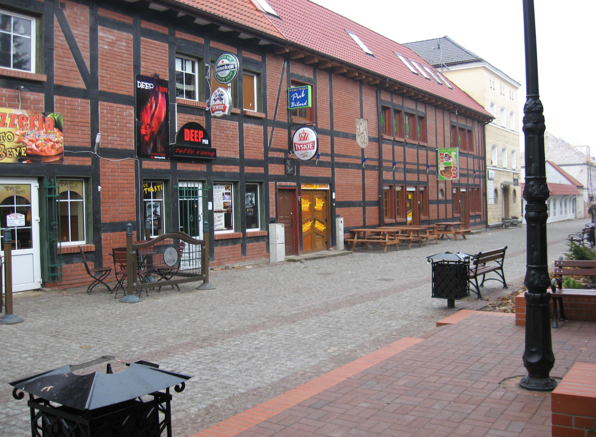

In [76]:
raw_image = Image.open(f"/home/xtest/projects/ped_all/images/2652.jpg").convert("RGB")
display(raw_image.resize((596, 437)))

In [ ]:
test_t2_df.to_csv("ped_images_t2_gt_df.csv", index=False, header=True)

In [ ]:
suggested_t2_df.to_csv("ped_images_t2_predict_df.csv", index=False, header=True)

## T3

In [114]:
t3 = ["transit", "station", "underground", "railway", "northgate"]
t3_img_ids = [2901, 178, 530, 3170, 157, 3688, 429, 2209, 631, 3121, 3078, 3455, 292, 1243, 533, 3054, 346, 670, 591, 1249, 454, 111, 461, 830, 215, 2022, 1206, 232, 1089, 2035, 95, 497, 2875, 318, 241, 583, 55, 2984, 894, 407, 2643, 3165, 490, 967, 3390, 2021, 2832, 3463, 2554, 3148, 3128, 1996, 293, 227, 3061, 527, 1158, 179, 2164, 440, 2868, 2023, 2926, 2591, 2124, 526, 2046, 462, 37, 2861, 3744, 170, 299, 3201, 595, 401, 321, 297, 1101, 2871, 327, 46, 506, 3687, 570, 549, 3140, 3087, 3264, 593, 545, 735, 2776, 592, 3508, 211, 1149, 2685, 3699, 3132]

In [115]:
print(t3_img_ids)

[2901, 178, 530, 3170, 157, 3688, 429, 2209, 631, 3121, 3078, 3455, 292, 1243, 533, 3054, 346, 670, 591, 1249, 454, 111, 461, 830, 215, 2022, 1206, 232, 1089, 2035, 95, 497, 2875, 318, 241, 583, 55, 2984, 894, 407, 2643, 3165, 490, 967, 3390, 2021, 2832, 3463, 2554, 3148, 3128, 1996, 293, 227, 3061, 527, 1158, 179, 2164, 440, 2868, 2023, 2926, 2591, 2124, 526, 2046, 462, 37, 2861, 3744, 170, 299, 3201, 595, 401, 321, 297, 1101, 2871, 327, 46, 506, 3687, 570, 549, 3140, 3087, 3264, 593, 545, 735, 2776, 592, 3508, 211, 1149, 2685, 3699, 3132]


In [116]:
t3_path = [base_path + str(img_id) + ".jpg" for img_id in t3_img_ids]

In [117]:
suggested_t3_df = get_vqa(t3_path, t3)

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


In [118]:
test_t3_df = suggested_t3_df.copy(deep=True)
# test_t2_df = test_t2_df.iloc[0:4]
test_t3_df

,transit,station,underground,railway,northgate,image_path
0,yes,yes,yes,yes,yes,/home/xtest/projects/ped_all/images/2901.jpg
1,yes,yes,no,no,no,/home/xtest/projects/ped_all/images/178.jpg
2,no,yes,no,yes,no,/home/xtest/projects/ped_all/images/530.jpg
3,no,yes,no,yes,no,/home/xtest/projects/ped_all/images/3170.jpg
4,no,yes,no,no,no,/home/xtest/projects/ped_all/images/157.jpg
...,...,...,...,...,...,...
95,no,yes,no,no,no,/home/xtest/projects/ped_all/images/211.jpg
96,no,no,no,no,no,/home/xtest/projects/ped_all/images/1149.jpg
97,no,no,no,no,yes,/home/xtest/projects/ped_all/images/2685.jpg
98,yes,no,no,yes,yes,/home/xtest/projects/ped_all/images/3699.jpg


In [119]:
image_widget = widgets.Image(value=b'')
output_widget = widgets.Output()

In [120]:

current_index = 0
total_images = len(test_t3_df)
# image_widget = widgets.Image(value=b'')
# output_widget = widgets.Output()

# List to store the data (image path and input values)


    # Update the stored data

# Create the "Next" button and define its behavior
next_button = widgets.Button(description="Next")

# Center-align the "Next" button
centered_next_button = widgets.HBox([widgets.Label(layout=widgets.Layout(flex='1')), next_button, widgets.Label(layout=widgets.Layout(flex='1'))])



# Assign the callback to the next button's on_click event
next_button.on_click(lambda b: next_button_callback(b, test_t3_df, t3))

# Create a VBox layout to display image, input boxes, and centered "Next" button
image_input_button_layout = widgets.VBox([image_widget, output_widget, centered_next_button])

# Display the initial image and centered "Next" button with input boxes
display(image_input_button_layout)
display_image(current_index, test_t3_df, t3)

In [123]:
test_t3_df

,transit,station,underground,railway,northgate,image_path
0,yes,yes,yes,yes,no,/home/xtest/projects/ped_all/images/2901.jpg
1,yes,yes,no,no,no,/home/xtest/projects/ped_all/images/178.jpg
2,yes,no,no,yes,no,/home/xtest/projects/ped_all/images/530.jpg
3,yes,yes,no,yes,no,/home/xtest/projects/ped_all/images/3170.jpg
4,no,yes,no,no,no,/home/xtest/projects/ped_all/images/157.jpg
...,...,...,...,...,...,...
95,yes,yes,no,no,no,/home/xtest/projects/ped_all/images/211.jpg
96,yes,no,no,no,no,/home/xtest/projects/ped_all/images/1149.jpg
97,yes,no,no,no,no,/home/xtest/projects/ped_all/images/2685.jpg
98,yes,yes,no,yes,no,/home/xtest/projects/ped_all/images/3699.jpg


In [124]:
suggested_t3_df

,transit,station,underground,railway,northgate,image_path
0,yes,yes,yes,yes,yes,/home/xtest/projects/ped_all/images/2901.jpg
1,yes,yes,no,no,no,/home/xtest/projects/ped_all/images/178.jpg
2,no,yes,no,yes,no,/home/xtest/projects/ped_all/images/530.jpg
3,no,yes,no,yes,no,/home/xtest/projects/ped_all/images/3170.jpg
4,no,yes,no,no,no,/home/xtest/projects/ped_all/images/157.jpg
...,...,...,...,...,...,...
95,no,yes,no,no,no,/home/xtest/projects/ped_all/images/211.jpg
96,no,no,no,no,no,/home/xtest/projects/ped_all/images/1149.jpg
97,no,no,no,no,yes,/home/xtest/projects/ped_all/images/2685.jpg
98,yes,no,no,yes,yes,/home/xtest/projects/ped_all/images/3699.jpg


In [125]:
test_t3_df.to_csv("ped_images_t3_gt_df.csv", index=False, header=True)

In [126]:
suggested_t3_df.to_csv("ped_images_t3_predict_df.csv", index=False, header=True)

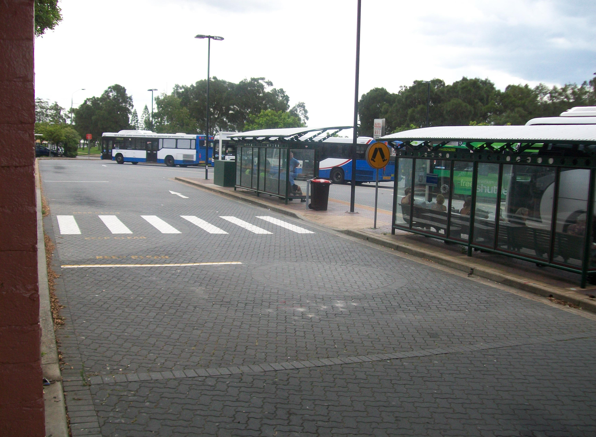

In [122]:
raw_image = Image.open(f"/home/xtest/projects/ped_all/images/178.jpg").convert("RGB")
display(raw_image.resize((596, 437)))

# Aircraft

In [ ]:
base_path = "/home/xtest/projects/av_all/images/"

## T1

In [24]:
t1 = [
                        "kite",
                        "balloon",
                        "fixed wing",
                        "glider",
                        "2008 utc reply"
                    ]
t1_img_ids = [3824, 2786, 3828, 188, 1466, 349, 140, 4482, 593, 247, 109, 275, 228, 3886, 4490, 480, 3888, 130, 160, 100, 106, 206, 117, 738, 686, 451, 487, 4649, 251, 4257, 1993, 261, 3355, 3816, 221, 233, 550, 1441, 243, 4626, 52, 3973, 4484, 4619, 455, 129, 2016, 646, 578, 616, 141, 254, 2017, 203, 2092, 3900, 3807, 2201, 1117, 1919, 3800, 2985, 3826, 499, 1965, 1192, 4574, 626, 833, 225, 1872, 4470, 4468, 3266, 1267, 1596, 4607, 978, 4509, 3020, 1840, 1244, 166, 584, 855, 4009, 1548, 299, 44, 2267, 1930, 4550, 1031, 93, 95, 3178, 796, 1961, 3827, 2081]

In [ ]:
t1_path = [base_path + str(img_id) + ".jpg" for img_id in t1_img_ids]
suggested_t1_df = get_vqa(t1_path, t1)
test_t1_df = suggested_t1_df.copy(deep=True)
# test_t2_df = test_t2_df.iloc[0:4]
test_t1_df

In [ ]:
image_widget = widgets.Image(value=b'')
output_widget = widgets.Output()

current_index = 0
total_images = len(test_t1_df)
# image_widget = widgets.Image(value=b'')
# output_widget = widgets.Output()

# List to store the data (image path and input values)


    # Update the stored data

# Create the "Next" button and define its behavior
next_button = widgets.Button(description="Next")

# Center-align the "Next" button
centered_next_button = widgets.HBox([widgets.Label(layout=widgets.Layout(flex='1')), next_button, widgets.Label(layout=widgets.Layout(flex='1'))])



# Assign the callback to the next button's on_click event
next_button.on_click(lambda b: next_button_callback(b, test_t1_df, t1))

# Create a VBox layout to display image, input boxes, and centered "Next" button
image_input_button_layout = widgets.VBox([image_widget, output_widget, centered_next_button])

# Display the initial image and centered "Next" button with input boxes
display(image_input_button_layout)
display_image(current_index, test_t1_df, t1)

In [ ]:
test_t1_df.to_csv("air_images_t1_gt_df.csv", index=False, header=True)

In [ ]:
suggested_t1_df.to_csv("air_images_t1_predict_df.csv", index=False, header=True)

### T2

In [27]:
t2 = [
                        "air national guard",
                        "use",
                        "bomber",
                        "national",
                        "unit"
                    ]
t2_img_ids = [499, 1022, 4427, 3402, 4464, 404, 3436, 3518, 3990, 2889, 1862, 2920, 1225, 3653, 4003, 4446, 577, 3324, 706, 944, 335, 4428, 20, 484, 3124, 2905, 3167, 1078, 4329, 44, 3009, 3902, 678, 4373, 814, 1133, 3483, 3545, 3627, 86, 4682, 1872, 3082, 616, 4358, 4, 3793, 35, 3357, 3872, 3762, 1270, 379, 378, 402, 4574, 3787, 1919, 3726, 2885, 1961, 2973, 2884, 3112, 893, 45, 3115, 4129, 3295, 646, 3474, 871, 1302, 804, 2121, 1005, 552, 610, 1843, 2017, 3195, 64, 1355, 3249, 1478, 945, 80, 1451, 370, 4150, 3916, 384, 4619, 918, 2715, 656, 2984, 1139, 193, 2911]

In [ ]:
t2_path = [base_path + str(img_id) + ".jpg" for img_id in t2_img_ids]
suggested_t2_df = get_vqa(t2_path, t2)
test_t2_df = suggested_t2_df.copy(deep=True)
test_t2_df

In [ ]:
image_widget = widgets.Image(value=b'')
output_widget = widgets.Output()

current_index = 0
total_images = len(test_t2_df)
# image_widget = widgets.Image(value=b'')
# output_widget = widgets.Output()

# List to store the data (image path and input values)


    # Update the stored data

# Create the "Next" button and define its behavior
next_button = widgets.Button(description="Next")

# Center-align the "Next" button
centered_next_button = widgets.HBox([widgets.Label(layout=widgets.Layout(flex='1')), next_button, widgets.Label(layout=widgets.Layout(flex='1'))])



# Assign the callback to the next button's on_click event
next_button.on_click(lambda b: next_button_callback(b, test_t2_df, t2))

# Create a VBox layout to display image, input boxes, and centered "Next" button
image_input_button_layout = widgets.VBox([image_widget, output_widget, centered_next_button])

# Display the initial image and centered "Next" button with input boxes
display(image_input_button_layout)
display_image(current_index, test_t2_df, t2)

In [ ]:
test_t2_df.to_csv("air_images_t2_gt_df.csv", index=False, header=True)

In [ ]:
suggested_t2_df.to_csv("air_images_t2_predict_df.csv", index=False, header=True)

### T3

In [30]:
# bad coverage data
t3 = [
                        "bypass",
                        "flow",
                        "temperature",
                        "pratt whitney",
                        "pressure"
                    ]
t3_img_ids = [275, 1965, 2051, 3565, 565, 4320, 2135, 2108, 1968, 3535, 2140, 455, 1959, 3848, 616, 328, 2763, 4369, 618, 3648, 2100, 514, 4484, 3583, 597, 1355, 141, 4588, 4446, 3432, 3474, 1466, 1561, 1880, 3750, 106, 3564, 1179, 4682, 1019, 3049, 284, 3266, 3462, 2981, 3973, 3641, 3329, 4456, 3676, 1972, 3844, 499, 604, 3863, 978, 577, 833, 3990, 3902, 1798, 4241, 1187, 3411, 2983, 953, 2847, 3532, 130, 4329, 2090, 2153, 3374, 3538, 330, 2126, 380, 179, 4645, 486, 3264, 2905, 1033, 3250, 3409, 3104, 2079, 3415, 3164, 3864, 4577, 4508, 2955, 3324, 3721, 4069, 738, 1861, 4481, 619]

In [ ]:
t3_path = [base_path + str(img_id) + ".jpg" for img_id in t3_img_ids]
suggested_t3_df = get_vqa(t3_path, t3)
test_t3_df = suggested_t3_df.copy(deep=True)
test_t3_df

In [ ]:
image_widget = widgets.Image(value=b'')
output_widget = widgets.Output()

current_index = 0
total_images = len(test_t3_df)
# image_widget = widgets.Image(value=b'')
# output_widget = widgets.Output()

# List to store the data (image path and input values)


    # Update the stored data

# Create the "Next" button and define its behavior
next_button = widgets.Button(description="Next")

# Center-align the "Next" button
centered_next_button = widgets.HBox([widgets.Label(layout=widgets.Layout(flex='1')), next_button, widgets.Label(layout=widgets.Layout(flex='1'))])



# Assign the callback to the next button's on_click event
next_button.on_click(lambda b: next_button_callback(b, test_t3_df, t3))

# Create a VBox layout to display image, input boxes, and centered "Next" button
image_input_button_layout = widgets.VBox([image_widget, output_widget, centered_next_button])

# Display the initial image and centered "Next" button with input boxes
display(image_input_button_layout)
display_image(current_index, test_t3_df, t3)

In [ ]:
test_t3_df.to_csv("air_images_t3_gt_df.csv", index=False, header=True)

In [ ]:
suggested_t3_df.to_csv("air_images_t3_predict_df.csv", index=False, header=True)